# Aggregate extraced time across multiple traces

1. Input parameters: directory with JSON traces, trace name pattern, (multiple) event patterns.  
   a. In trace name pattern, use one group for the varying parameter value (MBS).
2. For each event pattern, extract event time from all traces one by one using parseOneTrace script.
3. Aggregate values into one DF along with the varying parameter value extracted from the trace filename.


In [1]:
import os
import pandas as pd
import subprocess
import re
import string
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import cm
from sklearn import linear_model

## Set input parameters

In [2]:
logdir = 'logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont'
trace_name_pattern = 'nsys_trace_([0-9]+).json'
event_patterns = [
    'Iteration [123456789]+'
]


## Read trace files

In [3]:
list_command = "ls -1 " + logdir
files = []
param_values = []
proc = subprocess.Popen(list_command.split(" "),
                        stdout=subprocess.PIPE,
                        stderr=subprocess.STDOUT,
                        encoding='utf8')
for line in iter(proc.stdout.readline, ''):
    line = line.strip(" \n")
    m = re.match(trace_name_pattern, line)
    if m:
        files.append(os.path.abspath(os.path.join(logdir, line)))
        param_values.append(m.group(1))

print('{} files in {}'.format(len(files), logdir))
print(tuple(zip(files,param_values)))

27 files in logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont
(('/HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_10.json', '10'), ('/HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_100.json', '100'), ('/HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_110.json', '110'), ('/HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_12.json', '12'), ('/HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_120.json', '120'), ('/HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_130.json', '130'), ('/HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_140.json', '140'), ('/HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_15.json', '15'), ('/HDD2/ML/nsys

In [4]:
convert_traces = False

results = None
for param, tracefile in zip(param_values, files):
    events = '@'.join(event_patterns)
    print("Events: {}".format(events))
    if convert_traces:
        # Run
        # python3 parseOneTrace.py -f $tracefile --events $events
        command = 'python3@parseOneTrace.py@-f@{}@--events@{}'.format(
            tracefile, events)
        print(command.split('@'))
        p = subprocess.run(command.split('@'),
                           stdin=subprocess.PIPE,
                           stderr=subprocess.PIPE,
                           bufsize=0,
                           shell=False)
        if p.returncode == 0:
            print('Finished OK')
        else:
            if p.stdout is not None:
                print(p.stdout.decode('utf-8'))
            print('ERROR')
            print(p.stderr.decode('utf-8'))
    # Read data from CSV file
    directory = os.path.dirname(tracefile)
    csvfile = ('').join(os.path.basename(tracefile).split('.')
                        [:-1])  # Filename without extension
    csvfile = csvfile + '.csv'
    csvfile = os.path.join(directory, csvfile)
    print('Reading {}'.format(csvfile))
    df_ = pd.read_csv(csvfile)
    df_['param'] = param
    #     display(df_.head())
    if results is None:
        results = df_
    else:
        results = results.append(df_, ignore_index=True)

results.sample(n=8)

Events: Iteration [123456789]+
Reading /HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_10.csv
Events: Iteration [123456789]+
Reading /HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_100.csv
Events: Iteration [123456789]+
Reading /HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_110.csv
Events: Iteration [123456789]+
Reading /HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_12.csv
Events: Iteration [123456789]+
Reading /HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_120.csv
Events: Iteration [123456789]+
Reading /HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_130.csv
Events: Iteration [123456789]+
Reading /HDD2/ML/nsystraceparser/logs/p3.2xlarge.cont/traces/resnet18/20210209rerunNewCont/nsys_trace_140.csv
Events: Iterati

,name,start,end,duration,NVTX,corrID,GPU side,Type,param
377294,volta_sgemm_128x64_nt,10.249861,10.250220,0.000359,Iteration 3,15939.0,True,79.0,50
106574,elementwise_kernel,11.308645,11.308657,0.000011,Iteration 4,19305.0,True,79.0,130
152059,cudaMemsetAsync_v3020,10.169391,10.169425,0.000035,Iteration 5,28744.0,False,48.0,15
424467,elementwise_kernel,10.879636,10.879654,0.000018,Iteration 6,36013.0,False,48.0,60
204649,scalePackedTensor_kernel,14.266010,14.266019,0.000009,Iteration 11,64273.0,False,48.0,160
72682,elementwise_kernel,10.345686,10.345688,0.000001,Iteration 8,45778.0,True,79.0,12
317423,cudaBindTexture_v3020,9.603770,9.603778,0.000008,Iteration 1,5831.0,False,48.0,30
4063,elementwise_kernel,9.961382,9.961384,0.000001,Iteration 3,17990.0,True,79.0,10


In [5]:
# Get int number from string
def parseIteration(s):
    return int(s.strip(string.ascii_letters).strip(' ,'))
  

In [6]:
longtimes = results.copy()
longtimes['NVTX'] = longtimes['NVTX'].fillna('')

# # Calculate aggregate time for FWD pass, loss, BWD pass and optupdate for GPU and CPU for each MBS
# times = times[(times['name'].isin(['FWD pass', 'BWD pass','Prediction and loss','Optimizer update']))]
longtimes.loc[:,'iteration'] = longtimes["NVTX"].apply(parseIteration)
longtimes.drop(['NVTX'],axis=1,inplace=True)
longtimes[['param','corrID','Type']] = longtimes[['param','corrID','Type']].astype(int)
longtimes = longtimes[longtimes['iteration'].isin(range(2,12))]
print(longtimes['iteration'].unique())
print(longtimes['param'].unique())
display(longtimes.head(12))

[ 2  3  4  5  6  7  8  9 10 11]
[ 10 100 110  12 120 130 140  15 150 160 170 180 190  20 200  30  40   5
  50   6  60   7  70   8  80   9  90]


,name,start,end,duration,corrID,GPU side,Type,param,iteration
1279,cudaMemcpyAsync_v3020,9.865490,9.865510,0.000020,7028,False,48,10,2
1280,cudaStreamSynchronize_v3020,9.865511,9.866069,0.000558,7029,False,48,10,2
1281,cudaStreamSynchronize_v3020,9.865512,9.866068,0.000556,7029,True,106,10,2
1282,cudaMemcpyAsync_v3020,9.865514,9.866059,0.000545,7028,True,80,10,2
1283,cudaMemcpyAsync_v3020,9.866114,9.866129,0.000015,7037,False,48,10,2
1284,cudaStreamSynchronize_v3020,9.866130,9.866140,0.000010,7038,False,48,10,2
1285,cudaStreamSynchronize_v3020,9.866132,9.866140,0.000008,7038,True,106,10,2
1286,cudaMemcpyAsync_v3020,9.866134,9.866135,0.000001,7037,True,80,10,2
1287,elementwise_kernel,9.866179,9.866215,0.000037,7043,False,48,10,2
1288,elementwise_kernel,9.866215,9.866216,0.000001,7043,True,79,10,2


### Plot time per event 

In [7]:
def getColorList(cmap, n=16):
    cmap = cm.get_cmap(cmap,n)
    colors = []
    for i in range(cmap.N):
        c = matplotlib.colors.to_hex(cmap(i), keep_alpha=True)
        colors.append(c)
    return colors

,name,start,end,duration,corrID,GPU side,Type,param,iteration,hascorrID
1279,48 1 cudaMemcpyAsync_v3020,9.865490,9.865510,0.000020,7028,False,48,10,2,1
1280,48 1 cudaStreamSynchronize_v3020,9.865511,9.866069,0.000558,7029,False,48,10,2,1
1281,106 1 cudaStreamSynchronize_v3020,9.865512,9.866068,0.000556,7029,True,106,10,2,1
1282,80 1 cudaMemcpyAsync_v3020,9.865514,9.866059,0.000545,7028,True,80,10,2,1
1283,48 1 cudaMemcpyAsync_v3020,9.866114,9.866129,0.000015,7037,False,48,10,2,1


param,5,6,7,8,9,10,12,15,20,30,...,120,130,140,150,160,170,180,190,200,total
name,,,,,,,,,,,,,,,,,,,,,
48 1 cudaMemcpyAsync_v3020,0.000128,0.000111,0.000115,0.000108,0.000123,0.000108,0.000125,0.000137,0.000143,0.000154,...,0.047879,0.052028,0.052387,0.062140,0.063668,0.084367,0.088509,0.089957,0.103170,0.787158
48 1 elementwise_kernel,0.007403,0.006744,0.006961,0.007098,0.006652,0.006486,0.007124,0.008006,0.009771,0.010787,...,0.007235,0.008128,0.009033,0.008978,0.009547,0.007686,0.007919,0.008706,0.007479,0.214963
79 1 elementwise_kernel,0.001444,0.001525,0.001617,0.001695,0.001787,0.001859,0.002032,0.002273,0.002701,0.003529,...,0.010897,0.011799,0.012592,0.013361,0.014173,0.015068,0.015939,0.016697,0.017538,0.206985
79 1 volta_scudnn_winograd_128x128_ldg1_ldg4_relu_tile148t_nt_v1,0.001481,0.002900,0.002910,0.003163,0.003281,0.003320,0.001859,0.001284,0.001661,0.002464,...,0.009632,0.010411,0.011207,0.012005,0.012793,0.013558,0.014366,0.015164,0.015954,0.187957
79 1 volta_scudnn_128x64_stridedB_splitK_medium_nn_v1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.010588,0.011433,0.012273,0.013105,0.013944,0.014792,0.015651,0.016498,0.017339,0.176021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79 1 softmax_warp_backward,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000086
79 1 gemmSN_TN_kernel,0.000009,0.000010,0.000009,0.000010,0.000011,0.000011,0.000010,0.000009,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000079
79 1 gemmSN_NN_kernel,0.000008,0.000007,0.000006,0.000007,0.000008,0.000008,0.000008,0.000006,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000058


20


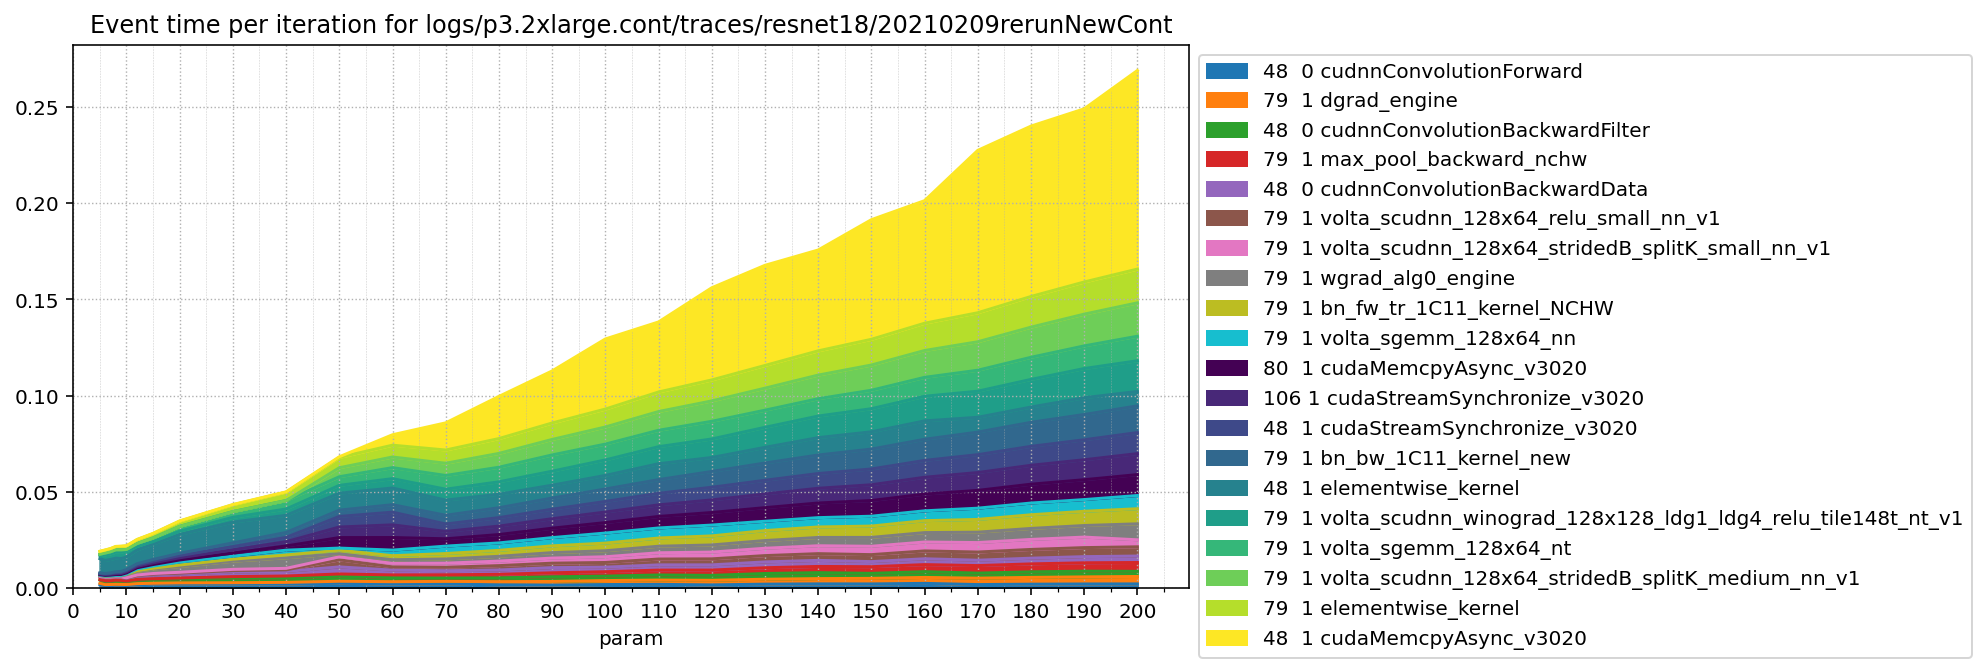

In [8]:
times  = longtimes.copy()
times.loc[:,'hascorrID'] = times.apply(lambda r: 1 if r.loc['corrID']>0 else 0, axis=1)
times.loc[:,'name'] = times.apply(lambda r: '{:<3d} {} {}'.format(r.loc['Type'],r.loc['hascorrID'],r.loc['name']), axis=1)
display(times.head())
ignorecolumns = ['start','end','corrID','hascorrID','Type']
times = times.drop(ignorecolumns,axis=1)
times = times.groupby(['param','name','iteration']).agg('sum').reset_index(drop=False)
times = times.groupby(['param','name']).agg('mean').reset_index(drop=False)
times.drop(['iteration'],axis=1,inplace=True)


times = times.pivot(index=['name'],values='duration',columns=['param']).fillna(0)
times.loc[:,'total'] = times.sum(axis=1)

times = times.sort_values(['total'],ascending=False)
display(times)
times.drop(['total'],axis=1,inplace=True)



df_ = times.head(20)
fig,ax = plt.subplots(figsize=(10,5),dpi=144)
col1 = getColorList('viridis',n=10)
col2 = getColorList('tab10',n=10)
# col3 = getColorList('tab20c',n=20)
colors = col2 + col1 
N = len(colors)
print(N)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=N)
df_.sort_values([100]).T.plot.area(cmap=cmap,ax=ax)
ax.set_xlim(0,None)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(ls=':', lw=0.7)
ax.grid(ls=':', lw=0.3, which='minor')
ax.set_title("Event time per iteration for {}".format(logdir))
leg = ax.legend(ncol=1, loc='upper left', bbox_to_anchor=(1,1))

In [9]:
# Sort events by their type
# GPU-side type 106 (Memcpy)
# GPU-side type other,
# CPU-side type 80 (cudaMemcpyAsync)
# CPU-side with corrID != 0
# CPU-side other

def sortEvents(times):
    times.loc[:,'kind'] = 'other'

    mask1 = (times['GPU side']==True)
#     mask2 = (times['Type']==106)
#     mask3 = (times['Type']==80)
    mask4 = (times['corrID']!=0)
    mask5a = (times['name'].str.contains('cudaMemcpyAsync')) 
    mask5b = (times['name'].str.contains('cudaStreamSynchronize'))
    mask5c = (times['name'].str.contains('cudaMemsetAsync'))
    times.loc[~mask1 & mask4, 'kind'] = 'CPU'
    times.loc[mask1 & ~(mask5a | mask5b | mask5c), 'kind'] = 'GPU'
    times.loc[mask1 & (mask5a | mask5c), 'kind'] = "Memcpy"
    times.loc[~mask1 & (mask5a | mask5b | mask5c), 'kind'] = 'other'
    return times


#     mask1 = (times['GPU side']==False)
#     mask2 = (times['name'].isin(['cudaStreamSynchronize_v3020','sem_timedwait','cudaHostAlloc_v3020']))    
#     mask1 = (times['corrID']==0)
#     times = times[~(mask1)]


memcpy = longtimes[(longtimes['name'].str.contains('cudaMemcpyAsync')) | (longtimes['name'].str.contains('cudaStreamSynchronize'))].copy()
display(memcpy)

times  = longtimes.copy()
# Drop MEMCPY operations
times = sortEvents(times)
ignorecolumns = ['start','end','corrID']
# display(times.head())
# Inspect "other" group


print("Memcpy")
memcpy =times[(times['kind']=='Memcpy')]
display( memcpy[memcpy['param']==200])
print(memcpy['name'].unique())

print('other')
other = times[times['kind']=='other']
display(other)
print(other['name'].unique())

print('corrID 33934')
display(times[times['corrID']==33934])

times = times.drop(ignorecolumns,axis=1)
times = times.groupby(['param','kind','iteration']).agg('sum').reset_index(drop=False)
times = times.groupby(['param','kind']).agg('mean').reset_index(drop=False)
times.drop(['iteration'],axis=1,inplace=True)


times = times.pivot(index=['kind'],values='duration',columns=['param']).fillna(0)
display(times)


# df_ = df_.sort_values(['total'],ascending=False).head(16)
# df_.drop(['total'],axis=1,inplace=True)

,name,start,end,duration,corrID,GPU side,Type,param,iteration
1279,cudaMemcpyAsync_v3020,9.865490,9.865510,0.000020,7028,False,48,10,2
1280,cudaStreamSynchronize_v3020,9.865511,9.866069,0.000558,7029,False,48,10,2
1281,cudaStreamSynchronize_v3020,9.865512,9.866068,0.000556,7029,True,106,10,2
1282,cudaMemcpyAsync_v3020,9.865514,9.866059,0.000545,7028,True,80,10,2
1283,cudaMemcpyAsync_v3020,9.866114,9.866129,0.000015,7037,False,48,10,2
...,...,...,...,...,...,...,...,...,...
548063,cudaMemcpyAsync_v3020,12.206876,12.206877,0.000001,59730,True,80,90,11
549497,cudaMemcpyAsync_v3020,12.248638,12.281887,0.033249,65489,False,48,90,11
549808,cudaMemcpyAsync_v3020,12.281870,12.281872,0.000002,65489,True,80,90,11
549809,cudaStreamSynchronize_v3020,12.281890,12.281915,0.000025,65490,False,48,90,11


Memcpy


,name,start,end,duration,corrID,GPU side,Type,param,iteration,kind
293512,cudaMemcpyAsync_v3020,11.437462,11.448333,0.010871,7352,True,80,200,2,Memcpy
293516,cudaMemcpyAsync_v3020,11.448416,11.448418,0.000002,7361,True,80,200,2,Memcpy
295047,cudaMemsetAsync_v3020,11.499006,11.499008,0.000002,9782,True,80,200,2,Memcpy
295137,cudaMemsetAsync_v3020,11.506227,11.506228,0.000001,10222,True,80,200,2,Memcpy
295161,cudaMemsetAsync_v3020,11.512671,11.512672,0.000001,10436,True,80,200,2,Memcpy
...,...,...,...,...,...,...,...,...,...,...
313822,cudaMemsetAsync_v3020,15.810793,15.810794,0.000001,66391,True,80,200,11,Memcpy
313835,cudaMemsetAsync_v3020,15.819393,15.819395,0.000001,66514,True,80,200,11,Memcpy
313847,cudaMemsetAsync_v3020,15.827370,15.827372,0.000001,66624,True,80,200,11,Memcpy
313860,cudaMemsetAsync_v3020,15.844162,15.844163,0.000001,66754,True,80,200,11,Memcpy


['cudaMemcpyAsync_v3020' 'cudaMemsetAsync_v3020']
other


,name,start,end,duration,corrID,GPU side,Type,param,iteration,kind
1279,cudaMemcpyAsync_v3020,9.865490,9.865510,0.000020,7028,False,48,10,2,other
1280,cudaStreamSynchronize_v3020,9.865511,9.866069,0.000558,7029,False,48,10,2,other
1281,cudaStreamSynchronize_v3020,9.865512,9.866068,0.000556,7029,True,106,10,2,other
1283,cudaMemcpyAsync_v3020,9.866114,9.866129,0.000015,7037,False,48,10,2,other
1284,cudaStreamSynchronize_v3020,9.866130,9.866140,0.000010,7038,False,48,10,2,other
...,...,...,...,...,...,...,...,...,...,...
549247,cudnnConvolutionBackwardFilter,12.240719,12.240803,0.000084,0,False,48,90,11,other
549248,cudaMemsetAsync_v3020,12.240722,12.240761,0.000039,64540,False,48,90,11,other
549497,cudaMemcpyAsync_v3020,12.248638,12.281887,0.033249,65489,False,48,90,11,other
549809,cudaStreamSynchronize_v3020,12.281890,12.281915,0.000025,65490,False,48,90,11,other


['cudaMemcpyAsync_v3020' 'cudaStreamSynchronize_v3020'
 'cudnnConvolutionForward' 'cudnnBatchNormalizationForwardTrainingEx'
 'cublasSetStream_v2' 'cublasSgemm_v2' 'cudaMemsetAsync_v3020'
 'cudnnBatchNormalizationBackwardEx' 'cudnnConvolutionBackwardData'
 'cudnnConvolutionBackwardFilter' 'cublasSgemmStridedBatched'
 'cublasGetMathMode' 'cublasSetMathMode' 'cublasCgemmBatched'
 'cublasCgemm3mStridedBatched']
corrID 33934


,name,start,end,duration,corrID,GPU side,Type,param,iteration,kind
89088,elementwise_kernel,11.338407,11.338426,0.000020,33934,False,48,120,6,CPU
89685,elementwise_kernel,11.357163,11.357174,0.000010,33934,True,79,120,6,GPU
195191,elementwise_kernel,12.255171,12.255184,0.000013,33934,False,48,160,6,CPU
195973,elementwise_kernel,12.289082,12.289092,0.000011,33934,True,79,160,6,GPU
281191,bn_bw_1C11_kernel_new,9.911357,9.911373,0.000016,33934,False,48,20,6,CPU
281193,bn_bw_1C11_kernel_new,9.911406,9.911457,0.000050,33934,True,79,20,6,GPU
302266,cudaMemsetAsync_v3020,12.860420,12.860495,0.000075,33934,False,48,200,6,other
303282,cudaMemsetAsync_v3020,12.892643,12.892644,0.000002,33934,True,80,200,6,Memcpy


param,5,6,7,8,9,10,12,15,20,30,...,110,120,130,140,150,160,170,180,190,200
kind,,,,,,,,,,,,,,,,,,,,,
CPU,0.012945,0.011954,0.012115,0.012329,0.011634,0.011088,0.012503,0.013847,0.017487,0.019114,...,0.014940,0.013469,0.015440,0.016776,0.015936,0.017363,0.014291,0.015020,0.016204,0.014808
GPU,0.007682,0.009284,0.009889,0.010595,0.011361,0.011914,0.013658,0.015592,0.020326,0.026413,...,0.088345,0.095221,0.105172,0.110624,0.118205,0.123923,0.133718,0.141123,0.147364,0.155275
Memcpy,0.000291,0.000344,0.000399,0.000452,0.000508,0.000566,0.000675,0.000840,0.001114,0.001655,...,0.005994,0.006539,0.007083,0.007625,0.008171,0.008709,0.009259,0.009799,0.010335,0.010886
other,0.007916,0.007609,0.007644,0.008162,0.008075,0.007506,0.009440,0.010697,0.011716,0.013789,...,0.058797,0.070876,0.077654,0.079614,0.089230,0.093192,0.113310,0.119281,0.122391,0.136248


16


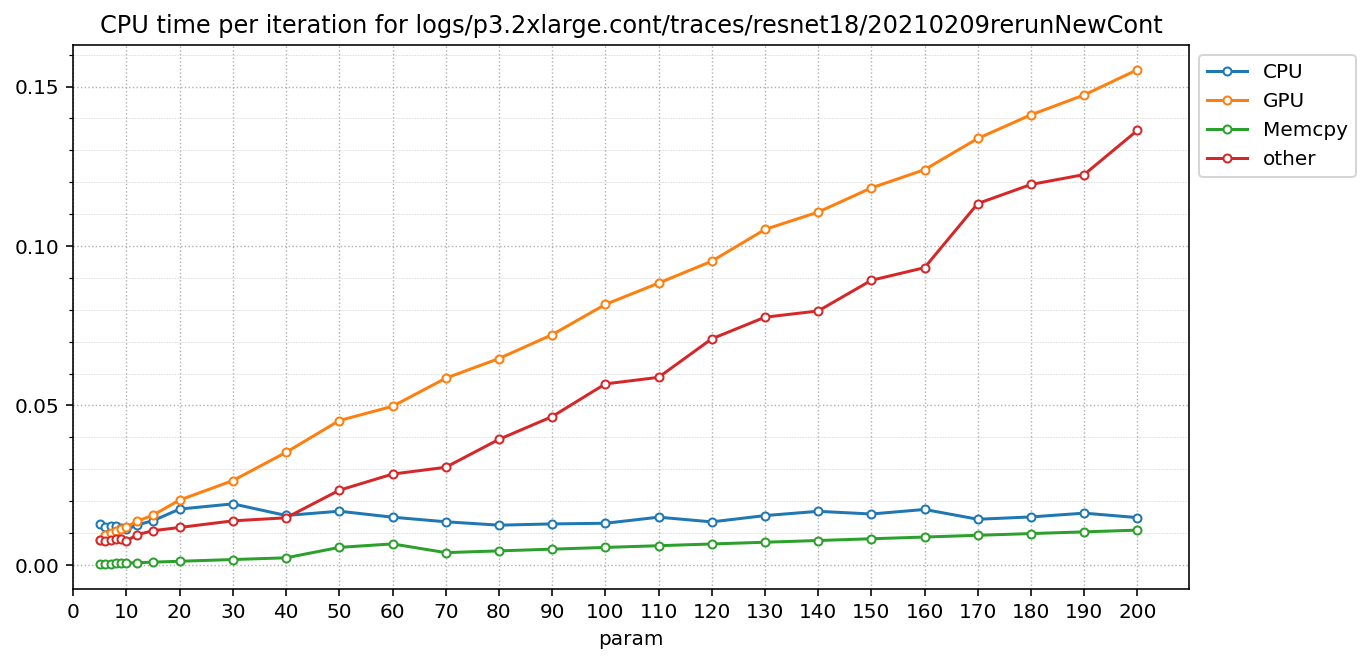

In [10]:
df_ = times.copy()
# df_ = df_.sort_values(['total'],ascending=False).head(16)
# df_.drop(['total'],axis=1,inplace=True)


fig,ax = plt.subplots(figsize=(10,5),dpi=144)
col1 = getColorList('viridis',n=6)
col2 = getColorList('tab10',n=10)
# col3 = getColorList('tab20c',n=20)
colors = col2 + col1 
N = len(colors)
print(N)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("combined", colors, N=N)
# df_.sort_values([200]).T.plot.area(cmap=cmap,ax=ax)
df_.T.plot(marker='o', ms=4, mfc='white', ax=ax)
ax.set_xlim(0,None)
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.grid(ls=':', lw=0.7)
ax.grid(ls=':', lw=0.3, which='minor')
ax.set_title("CPU time per iteration for {}".format(logdir))
leg = ax.legend(ncol=1, loc='upper left', bbox_to_anchor=(1,1))

## Read IO time

In [18]:
dataiodir = "../mlbench/pytorch/logs/p3.2xlarge.cont/iterseries/resnet18_3_20210224/"
dataio = pd.read_csv(os.path.join(dataiodir,"avg.csv"))
dataio.set_index("batch",drop=True,inplace=True)
dataio = dataio/1000. # Convert ms to s
dataio.head()

,median_read_time,mean_read_time
batch,,
5,0.001991,0.001989
6,0.002009,0.002007
7,0.001881,0.001867
8,0.002050,0.002041
9,0.001971,0.002019


In [19]:
dataio.loc[:,"median_read_time"] = dataio["median_read_time"] * dataio.index.values
dataio.loc[:,"mean_read_time"]= dataio["mean_read_time"] * dataio.index.values
dataio.head()

,median_read_time,mean_read_time
batch,,
5,0.009957,0.009946
6,0.012054,0.012041
7,0.013163,0.013069
8,0.016396,0.016329
9,0.017736,0.018168


## Plot iteration times

In [20]:
df_CPUGPU = times.T
df_CPUGPU.loc[:,"GPU"] = df_CPUGPU[['GPU','Memcpy']].sum(axis=1)
df_CPUGPU.drop(['other','Memcpy'],axis=1,inplace=True)
df_CPUGPU.head()

kind,CPU,GPU
param,,
5,0.012945,0.008265
6,0.011954,0.009972
7,0.012115,0.010687
8,0.012329,0.011499
9,0.011634,0.012377


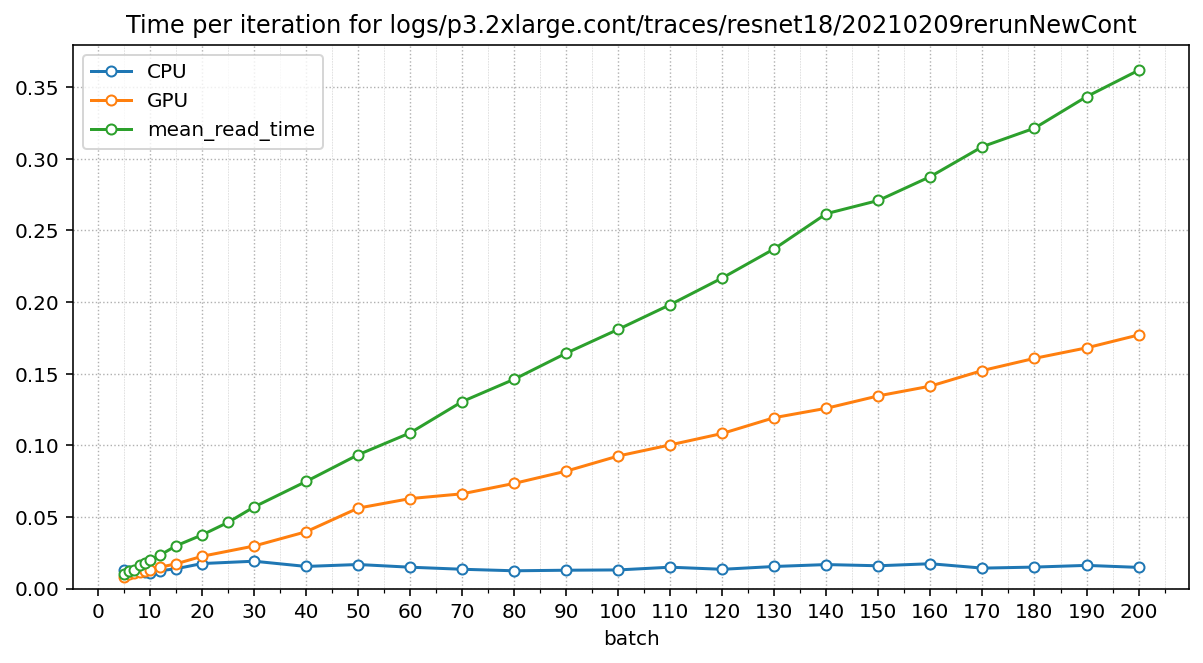

In [21]:
fig,ax = plt.subplots(figsize=(10,5),dpi=144)
df_CPUGPU.plot(ms=5,mfc='white',marker='o',ax=ax)
dataio.plot(y='mean_read_time',use_index=True, ms=5,mfc='white',marker='o',ax=ax)
ax.set_ylim([0,None])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(ls=':', lw=0.7)
ax.grid(ls=':', lw=0.3, which='minor')
ax.set_title("Time per iteration for {}".format(logdir))
ax.legend()
plt.show()   

## Compare with time logs

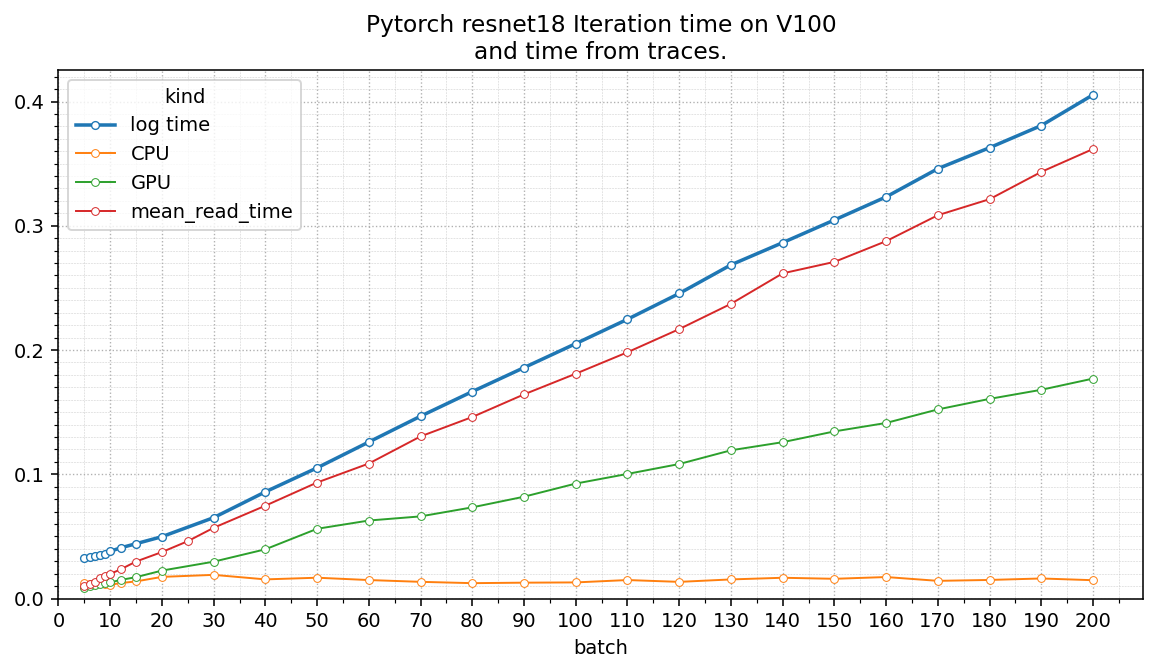

In [30]:
clean_logs = pd.read_csv("../mlbench/pytorch/logs/p3.2xlarge.cont/batchseries/imagenet/pytorch1.4.0_resnet18_20210209/clean_logs.csv")


clean_logs['itertime'] = clean_logs['time']/clean_logs['iterations']
# Plottable value
clean_logs['value'] = clean_logs['itertime'] 
clean_logs = clean_logs.groupby(['batch']).agg('mean')
clean_logs = clean_logs[['value']]
clean_logs.index.name = None

fig,ax = plt.subplots(figsize=(10,5),dpi=140)
clean_logs.rename(columns={"value":"log time"}).loc[clean_logs.index<=200,:].plot(marker='o',ms=4,mew=0.7,lw=1.8,mfc='white',ax=ax)
df_CPUGPU.plot(ms=4,mew=0.5,lw=1,mfc='white',marker='o',ax=ax)
dataio.plot(y='mean_read_time',use_index=True, ms=4,mew=0.5,lw=1,mfc='white',marker='o',ax=ax)
ax.set_ylim([0,None])
ax.set_xlim([0,None])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.grid(ls=':', lw=0.3, which='minor')
ax.grid(ls=':', lw=0.7)

ax.set_title("Pytorch resnet18 Iteration time on V100\nand time from traces.")

plt.show()

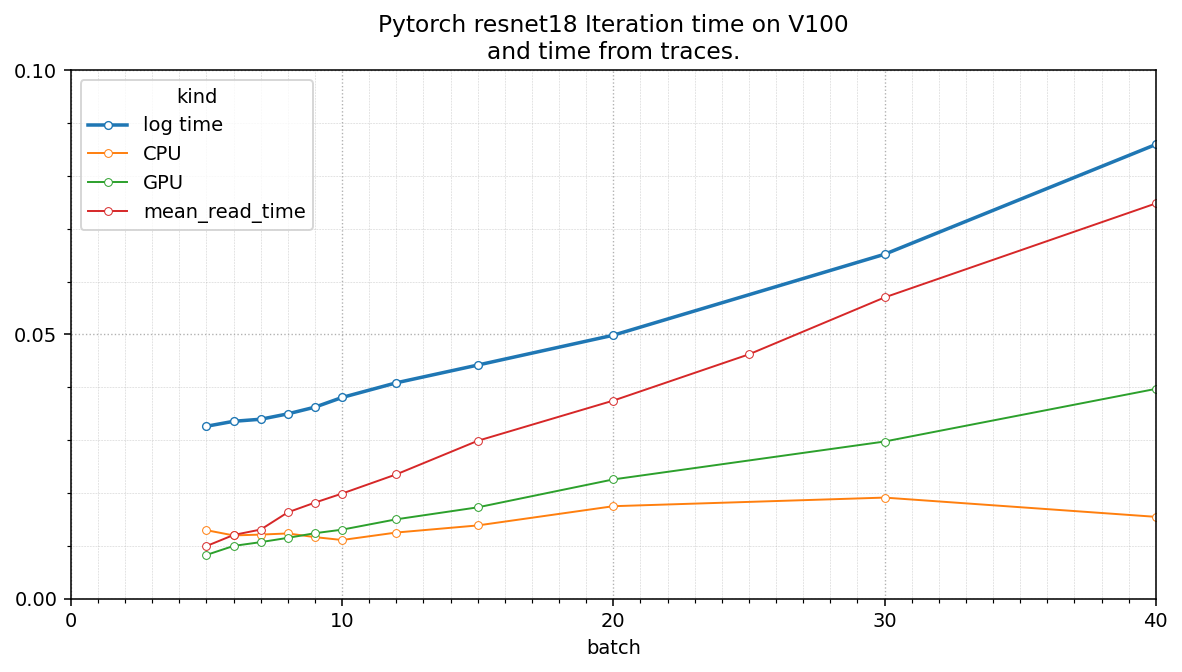

In [31]:
clean_logs = pd.read_csv("../mlbench/pytorch/logs/p3.2xlarge.cont/batchseries/imagenet/pytorch1.4.0_resnet18_20210209/clean_logs.csv")


clean_logs['itertime'] = clean_logs['time']/clean_logs['iterations']
# Plottable value
clean_logs['value'] = clean_logs['itertime'] 
clean_logs = clean_logs.groupby(['batch']).agg('mean')
clean_logs = clean_logs[['value']]
clean_logs.index.name = None

fig,ax = plt.subplots(figsize=(10,5),dpi=140)
clean_logs.rename(columns={"value":"log time"}).loc[clean_logs.index<=200,:].plot(marker='o',ms=4,mew=0.7,lw=1.8,mfc='white',ax=ax)
df_CPUGPU.plot(ms=4,mew=0.5,lw=1,mfc='white',marker='o',ax=ax)
dataio.plot(y='mean_read_time',use_index=True, ms=4,mew=0.5,lw=1,mfc='white',marker='o',ax=ax)
ax.set_ylim([0,0.1])
ax.set_xlim([0,40])
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))
ax.grid(ls=':', lw=0.3, which='minor')
ax.grid(ls=':', lw=0.7)

ax.set_title("Pytorch resnet18 Iteration time on V100\nand time from traces.")

plt.show()

## Approximations

### Approximate CPU time with LR

In [27]:
# Approximate column from DF with LR,
# Return model predictions.
def approximateWithLR(df,column):
    X = df.index.values
    Y = df[column].values
    model = linear_model.LinearRegression(fit_intercept=True,
                                              normalize=True)
    try:
        model = model.fit(X.reshape(-1,1),Y)
    except Exception as e:
        print(e)
        display(df)
        return None
    predictions = model.predict(X.reshape(-1,1))
    return predictions,model
    
    

In [29]:
df_

kind,CPU,GPU
param,,
5,0.025444,0.007999
6,0.026223,0.009651
7,0.026819,0.010320
8,0.027875,0.011059
9,0.029923,0.011897
10,0.031496,0.012484
12,0.033514,0.014319
15,0.034886,0.016424
20,0.038498,0.021376


AttributeError: 'Series' object has no attribute 'query'

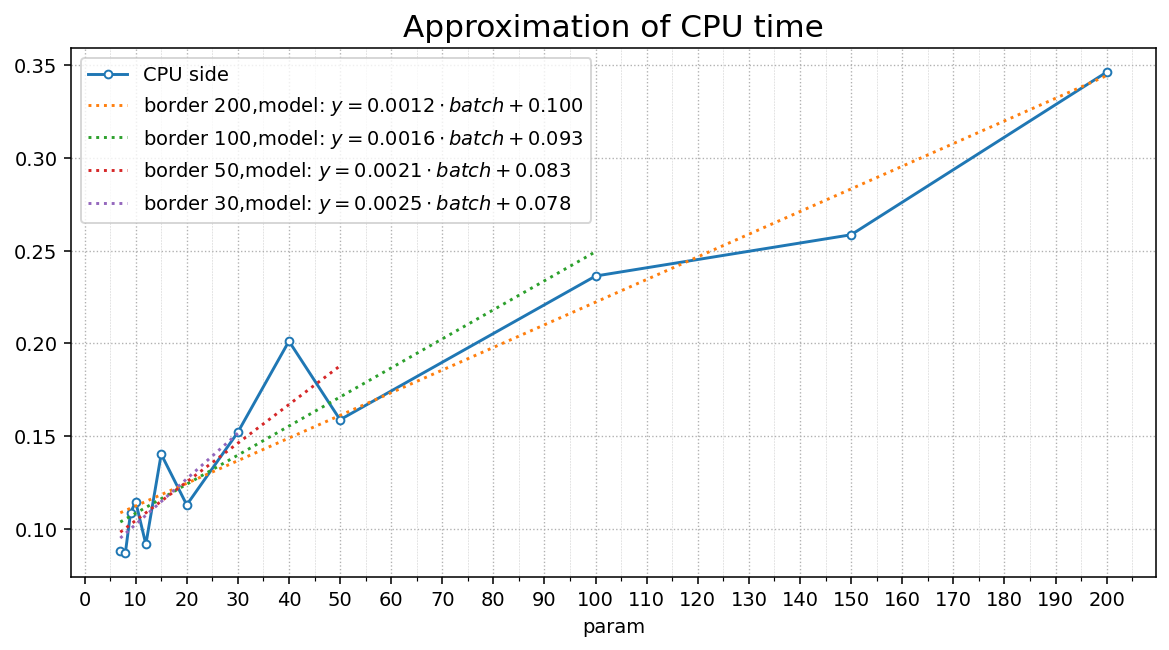

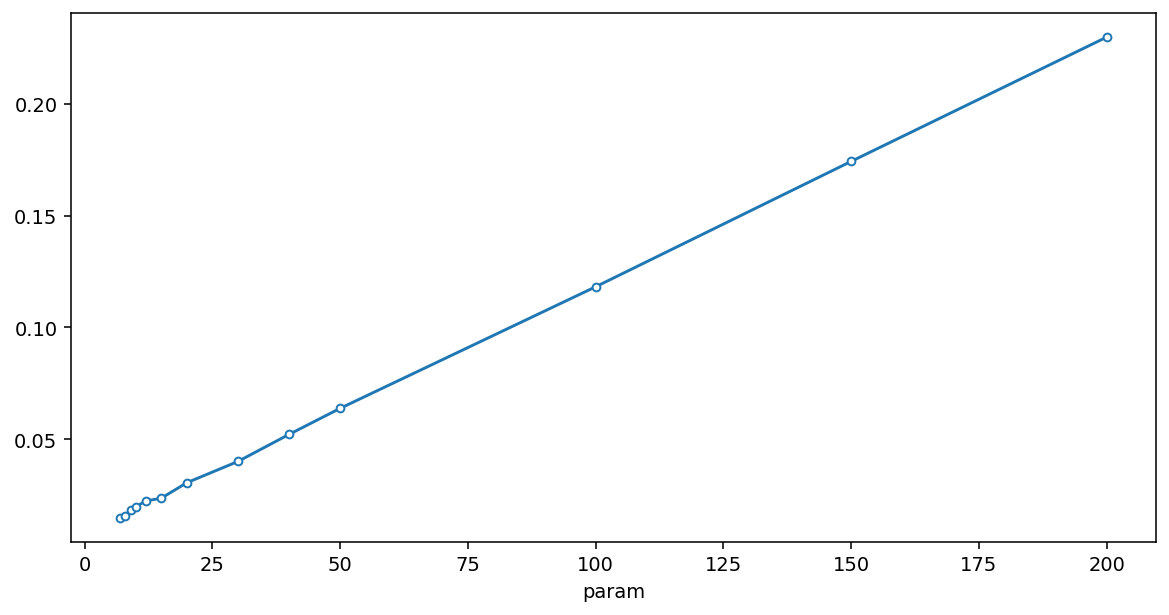

In [96]:
fig,ax = plt.subplots(figsize=(10,5),dpi=140)
# df_ = timesT.loc[:, ["CPU side"]].copy()
df_.plot(marker='o',ms=4,mfc='white',ax=ax)
for border in [200, 100, 50, 30]:
    df_ = timesT.loc[:, ["CPU side"]].query("index<=@border")
    predictions, model = approximateWithLR(df_, "CPU side")
    X = df_.index.values
    ax.plot(X,
            predictions,ls=":",
            label="border {},model: $y={:.4f} \cdot batch {:+.3f}$".format(
                border, model.coef_[0], model.intercept_))
ax.set_title("Approximation of CPU time", fontsize=16)
ax.legend()
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(ls=':', lw=0.7)
ax.grid(ls=':', lw=0.3, which='minor')

fig,ax = plt.subplots(figsize=(10,5),dpi=140)
df_ = timesT.loc[:, "GPU side"].copy()
df_.plot(marker='o',ms=4,mfc='white',ax=ax)
for border in [200, 100, 50, 30]:
    df_ = timesT.loc[:, "GPU side"].query("index>=@border")
    predictions, model = approximateWithLR(df_, "GPUtime")
    X = df_.index.values
    ax.plot(X,
            predictions,ls=":",
            label="border {},model: $y={:.5f} \cdot batch {:+.5f}$".format(
                border, model.coef_[0], model.intercept_))
ax.set_title("Approximation of GPU time", fontsize=16)
ax.legend()
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.grid(ls=':', lw=0.7)
ax.grid(ls=':', lw=0.3, which='minor')

plt.show()